In [1]:
import keras
from keras.models import Model
from keras.layers import *
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
IMAGE_SIZE = 224
NUM_CLASSES = 5
BATCH_SIZE = 32
CLASS_MAP = ['car', 'truck', 'pedestrian', 'bicyclist', 'light']

# DATA

### Download the Dataset

In [ ]:
!kaggle datasets download -d alincijov/self-driving-cars
!unzip 'self-driving-cars.zip' -d 'Dataset'

### Loading the Datasets

In [4]:
labels = pd.read_csv("Dataset/labels_trainval.csv")
len(labels)

165105

In [5]:
num_images = len(labels['frame'].unique())
num_images

22241

In [6]:
labels = labels.sort_values('frame')
labels.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1


In [7]:
def format_images(img, name):
    return tf.cast(img, tf.uint8)

In [10]:
images = tf.keras.utils.image_dataset_from_directory("Dataset", image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=1, shuffle=False).map(format_images)
images, len(images)

Found 22241 files belonging to 1 classes.


(<_MapDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None)>,
 22241)

### Testing the Dataset

{'car', 'pedestrian'}


(-0.5, 223.5, 223.5, -0.5)

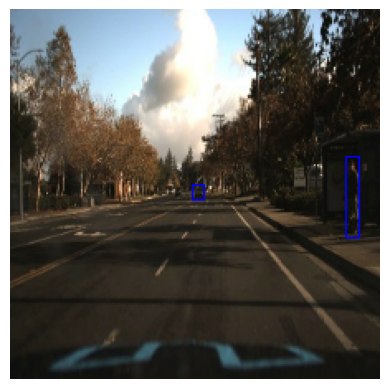

In [11]:
sample_frame = labels.loc[0]['frame']
sample_labels = labels[labels['frame']==sample_frame]

sample_image = images.as_numpy_iterator().next()[0]
classes = []
img = np.array(sample_image)
for _, sample in sample_labels.iterrows():
    cv2.rectangle(img, (int(sample['xmin']*IMAGE_SIZE/480), int(sample['ymin']*IMAGE_SIZE/300)), (int(sample['xmax']*IMAGE_SIZE/480), int(sample['ymax']*IMAGE_SIZE/300)), (0, 0, 255), 1)
    classes.append(CLASS_MAP[sample['class_id']-1])

print(set(classes))
plt.imshow(img)
plt.axis('off')

### Preprocessing the Dataset

### Transform Input For YOLO

In [12]:
def yolo_input(dataframe):
    label_matrix = tf.Variable(lambda: tf.zeros((7, 7, NUM_CLASSES+5), dtype=tf.float32))
    for _, row in dataframe.iterrows():
        y_min, x_min, y_max, x_max = row['ymin'], row['xmin'], row['ymax'], row['xmax']
        w = x_max - x_min
        h = y_max - y_min
        x = x_min + w / 2
        y = y_min + h / 2
        c = int(row['class_id']-1)

        x_cell, y_cell = 7. * x / 480., 7. * y / 300.      # Location relative to the cell

        i, j = int(x_cell), int(y_cell)    # Which cell is responsible for the box

        if label_matrix[i, j, NUM_CLASSES] == 0:
            label_matrix[i, j, NUM_CLASSES:NUM_CLASSES+5].assign((1., x_cell%1, y_cell%1, w/480., h/300.))
            label_matrix[i, j, c].assign(1.)

    return label_matrix

In [ ]:
final_labels = []
for frame_id in labels['frame'].unique():
    same_frame = labels[labels['frame']==frame_id]
    final_labels.append(yolo_input(same_frame))

### Converting to Tensorflow Dataset

In [ ]:
final_labels = np.array(final_labels, dtype=np.float32)
final_labels = tf.data.Dataset.from_tensor_slices(final_labels)

In [ ]:
dataset = tf.data.Dataset.zip((images.unbatch(), final_labels))
train = dataset.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# MODEL

### Buiding the Model

In [ ]:
class YOLO(Model):
    def __init__(self):
        super(YOLO, self).__init__()

        self.backbone = tf.keras.applications.resnet50.ResNet50(
            weights='imagenet',
            input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
            include_top=False,
        )
        self.backbone.trainable = False
        self.detector = self.build_model()


    def build_model(self):
        def conv_block(filters, kernel, strides, padding, input):
            x = Conv2D(filters, kernel, strides, padding, use_bias=False)(input)
            x = BatchNormalization()(x)
            return LeakyReLU(0.1)(x)

        def repetition_block(filters, repetitions, input):
            x = conv_block(filters, 1, 1, 'same', input)
            x = conv_block(filters*2, 3, 1, 'same', x)
            if repetitions!= 1:
                for _ in range(1, repetitions):
                    x = conv_block(filters, 1, 1, 'same', x)
                    x = conv_block(filters*2, 3, 1, 'same', x)
            return x

        def fully_connected(input):
            x = Dense(512)(input)
            x = Dropout(0.5)(x)
            x = LeakyReLU(0.1)(x)
            x = Dense(7*7*(NUM_CLASSES + 2*5), 'sigmoid')(x)
            return Reshape((7, 7, NUM_CLASSES + 2*5))(x)

        input = Input((448, 448, 3))

        x = Lambda(tf.keras.applications.resnet50.preprocess_input)(input)
        x = self.backbone(x)

        x = Conv2D(512, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.1)(x)

        x = Conv2D(512, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.1)(x)

        x = Conv2D(512, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.1)(x)

        x = Conv2D(512, 3, padding='same')(x)
        x = LeakyReLU(0.1)(x)

        x = Flatten()(x)
        out = fully_connected(x)

        return Model(inputs = input, outputs = out)

In [ ]:
model = YOLO()

### Training the Model

In [ ]:
def intersection_over_union(boxes2, boxes1):
    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                         boxes1[..., 1] - boxes1[..., 3] / 2.0,
                         boxes1[..., 0] + boxes1[..., 2] / 2.0,
                         boxes1[..., 1] + boxes1[..., 3] / 2.0],
                        axis=-1)

    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                         boxes2[..., 1] - boxes2[..., 3] / 2.0,
                         boxes2[..., 0] + boxes2[..., 2] / 2.0,
                         boxes2[..., 1] + boxes2[..., 3] / 2.0],
                        axis=-1)
    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

    intersection = tf.maximum(0.0, rd - lu)
    inter_square = intersection[..., 0] * intersection[..., 1]

    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]

    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)
    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)


def yolo_loss(y_true, y_pred):
    iou_b1 = intersection_over_union(y_pred[..., 6:10], y_true[..., 6:10])
    iou_b2 = intersection_over_union(y_pred[..., 11:15], y_true[..., 6:10])

    bestbox  = tf.expand_dims(tf.cast(tf.math.greater_equal(iou_b2, iou_b1), tf.float32), -1)
    exists_box = tf.expand_dims(y_true[..., 5], axis=3)

    # BOX LOSS

    box_predictions = exists_box * (
      (
        bestbox * y_pred[..., 11:15]
        + (1. - bestbox) * y_pred[..., 6:10]
      )
    )

    box_targets = exists_box * y_true[..., 6:10]

    modified_y_pred = tf.math.sign(box_predictions[..., 2:4]) * tf.math.sqrt(tf.math.abs(box_predictions[..., 2:4] + 1e-6))
    modified_targets = tf.math.sqrt(box_targets[..., 2:4])
    box_targets = tf.concat([box_targets[..., :2], modified_targets, box_targets[..., 4:]], axis=-1)
    box_predictions = tf.concat([box_predictions[..., :2], modified_y_pred, box_predictions[..., 4:]], axis=-1)

    box_loss = tf.keras.losses.MeanSquaredError()(
        tf.reshape(box_targets, [-1, 4]),
        tf.reshape(box_predictions, [-1, 4]))

    # OBJECT LOSS

    pred_box = bestbox * y_pred[..., 10:11] + (1 - bestbox) * y_pred[..., 5:6]

    object_loss = tf.keras.losses.MeanSquaredError()(
        tf.reshape(exists_box * y_true[..., 5:6], [-1, 1]),
        tf.reshape(exists_box * pred_box, [-1, 1]))

    # NO OBJECT LOSS

    no_object_loss = tf.keras.losses.MeanSquaredError()(
      tf.reshape((1 - exists_box) * y_true[..., 5:6], [-1, 7*7]),
      tf.reshape((1 - exists_box) * y_pred[..., 5:6], [-1, 7 * 7]))
    no_object_loss += tf.keras.losses.MeanSquaredError()(
        tf.reshape((1 - exists_box) * y_true[..., 5:6], [-1, 7 * 7]),
        tf.reshape((1 - exists_box) * y_pred[..., 10:11], [-1, 7 * 7]))

    # CLASS LOSS

    class_loss = tf.keras.losses.MeanSquaredError()(
            tf.reshape(exists_box * y_true[..., :5], (-1, 5)),
            tf.reshape(exists_box * y_pred[..., :5], (-1, 5))
        )

    # YOLO LOSS

    return (
            5. * box_loss
            + object_loss
            + 0.5 * no_object_loss
            + class_loss
        )

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return 1e-4
    elif epoch >= 30 and epoch <= 75:
        return 5e-5
    else:
        return 1e-5

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping('loss', patience=10, restore_best_weights=True)

model.detector.compile(keras.optimizers.Adam(1e-4), yolo_loss)
model.detector.fit(train, epochs=135, callbacks=[early_stopping, lr_callback])

### Testing the Model

In [ ]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

def convert_cellboxes(predictions):
    batch_size = tf.shape(predictions)[0]
    predictions = predictions.reshape(batch_size, 7, 7, 15)

    converted_preds_class = []
    converted_preds_bbox = []
    converted_preds_score = []

    for prediction in predictions:
        preds_class = []
        preds_bbox = []
        preds_score = []

        for i in range(7):
            for j in range(7):
                bbox1 = prediction[i, j, 6:10]
                bbox2 = prediction[i, j, 11:15]
                score1 = prediction[i, j, 5]
                score2 = prediction[i, j, 10]
                if score1>=0.25 or score2>=0.25:
                    class_idx = tf.argmax(prediction[i, j, :5])

                    best_box = bbox1 if score1>score2 else bbox2

                    x_cell, y_cell, width_cell, height_cell = best_box
                    x = (i + x_cell) / 7
                    y = (j + y_cell) / 7
                    w = width_cell 
                    h = height_cell 

                    x_min = x - w / 2
                    y_min = y - h / 2
                    x_max = x + w / 2
                    y_max = y + h / 2


                    preds_class.append(class_idx)
                    preds_bbox.append([x_min, y_min, x_max, y_max])
                    preds_score.append(score1 if score1>score2 else score2)

        converted_preds_class.append(preds_class)
        converted_preds_bbox.append(preds_bbox)
        converted_preds_score.append(preds_score)


    return converted_preds_class, converted_preds_bbox, converted_preds_score

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


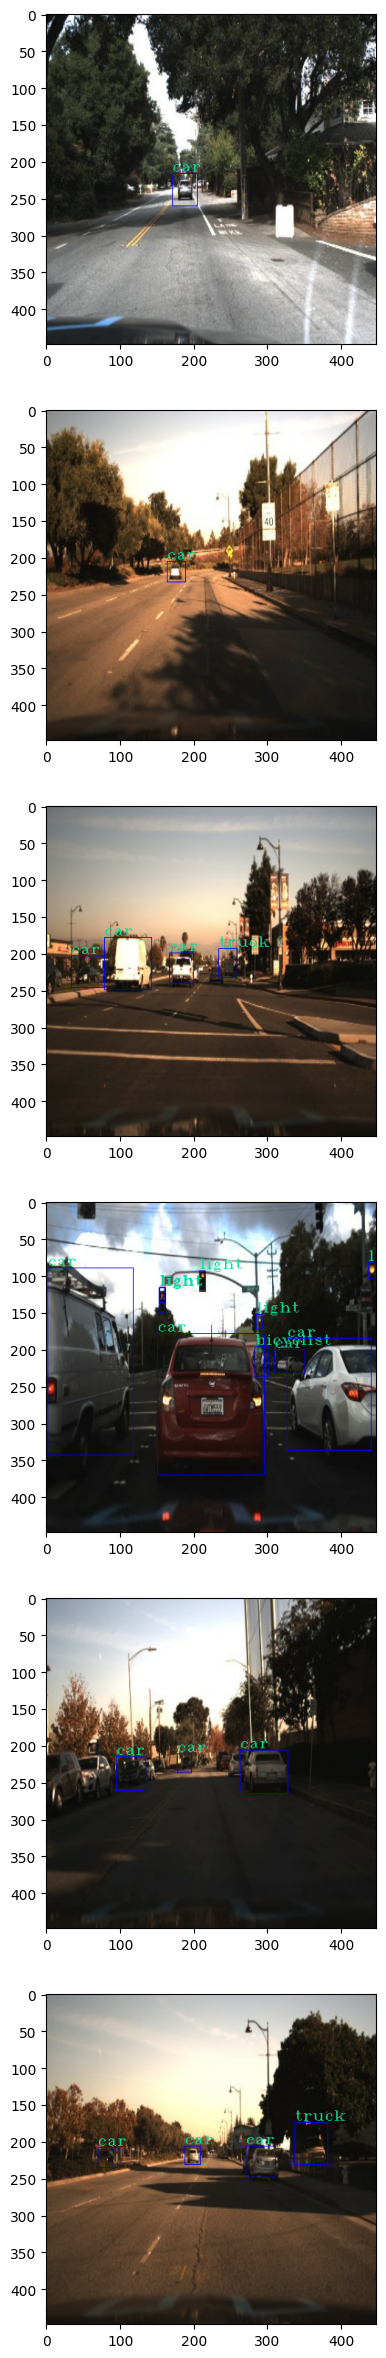

In [ ]:
samples = train.as_numpy_iterator().next()

cell_box_preds = model.detector.predict(samples[0])
class_preds, bbox_preds, scores_preds = convert_cellboxes(cell_box_preds)
final_bboxes = [tf.image.non_max_suppression(bboxes, scores, 100, iou_threshold=0.5) for bboxes,scores in zip(bbox_preds, scores_preds)]
final_bboxes[0].shape

fig, axes = plt.subplots(6, 1, figsize=(5, 30))
for i in range(6):
    img = np.array(samples[0][i])
    for j in final_bboxes[i]:
        box = np.array(tf.multiply(bbox_preds[i][j], 448), dtype=np.int64)
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 1)
        cv2.putText(
          img,
          CLASS_MAP[class_preds[i][j]],
          (box[0],box[1]-3),
          cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(2,225,155),1
          )

    axes[i].imshow(img)

### Saving the Model

In [ ]:
model.detector.save('YOLO.h5')